# FBA with E. coli mutants

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import cobra, requests, os

# Functions

In [50]:
def float_convert(x):
    try:
        y = float(x)
    except:
        y = None
    return y

# Load

In [51]:
"""TnSeq data"""
# Skip these cols
skip_cols = ['orgId', 'locusId', 'sysName', 'desc']
tnseq = pd.read_csv('ecoli_tnseq.tsv', '\t', index_col='geneName')
tnseq = tnseq[[c for c in tnseq if c not in skip_cols]]

# Metadata
md = pd.read_csv('ecoli_md.tsv', '\t')
md['Sample'] = md[['expName', 'expDesc']].apply(lambda x: ' '.join(x), 1)
md['concentration_1'] = md.concentration_1.apply(float_convert)
md['condition'] = md[['aerobic', 'condition_1', 'condition_2']].astype(str).apply(lambda x: '_'.join(x), 1)

"""Media"""
# Get SEED <-> BIGG mappings
aliases = pd.read_csv('https://raw.githubusercontent.com/ModelSEED/ModelSEEDDatabase/master/Biochemistry/Aliases/Unique_ModelSEED_Compound_Aliases.txt', '\t')
# LB Media
lb_df = pd.read_csv('kb_media.2770.tsv', '\t')
# M9 media
# M9 media from https://www.nature.com/articles/s41586-018-0124-0#Sec36 Table S18
# tnseq_medias = pd.read_excel('https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-018-0124-0/MediaObjects/41586_2018_124_MOESM3_ESM.xlsx', 'TableS18_Medias', engine='openpyxl', header=4)
# m9_no_c = """Magnesium sulfate
# Calcium chloride
# Sodium phosphate dibasic heptahydrate
# Potassium phosphate monobasic
# Sodium Chloride
# Ammonium chloride""".split('\n')

# m9_no_n = """D-Glucose
# Magnesium sulfate
# Calcium chloride
# Sodium phosphate dibasic heptahydrate
# Potassium phosphate monobasic
# Sodium Chloride""".split('\n')

"""Model"""
model = cobra.io.read_sbml_model('ecoli_model.xml')

model

Name,iJO1366
Memory address,0x02b91674b0760
Number of metabolites,1805
Number of reactions,2583
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


# Define media

## M9

In [60]:
"Base M9 media"
ilija_m9 = pd.read_excel('Carbon-D-Glucose.xls')
m9_seed = ilija_m9[~ilija_m9.name.isin(['NH3', 'D-Glucose'])].compounds.unique()

m9_base_bigg_ids = aliases.loc[aliases['ModelSEED ID'].isin(m9_seed) & aliases.Source.eq('BiGG'), 'External ID'].unique()  + '_e'

m9_base_metabs = [m for m in model.metabolites if m.id in m9_base_bigg_ids]
# Get exchange reactions associate with lb media metabolites
m9_base = [r.id for r in model.exchanges if any(m in r.metabolites for m in m9_base_metabs)]

m9_no_c = ['EX_nh4_e'] + m9_base
m9_no_n = ['EX_glc__D_e'] + m9_base

"""M9 base media"""
# Extract all components from M9
m9_components = list(set([i.lower() for m in [m9_no_c, m9_no_n] for c in m for i in c.split(' ')]))
m9_components.extend(['ammonia', 'k+', 'mg'])

# Get exchange reactions associated with m9
m9_rxns = {c: r.id for c in m9_components for r in model.exchanges if r.name.lower().split(' exchange')[0] == c}

"""M9 supplements"""
# Get reactions for supplements
m9_supps = md[md.media.isin(['M9 minimal media_noCarbon', 'M9 minimal media_noNitrogen'])].condition_1.unique()
bads = ['Sodium D,L-Lactate']
m9_supps = [s for s in m9_supps if s not in bads]
#### TODO: FINISH PROGRAMATICALLY REPLACE WITH BIGG FRIENDLY NAMES Replace 
replacements = {'d-gluconic'.lower(): 'D-Gluconate'.lower(), 'd-glucuronic': 'D-Glucuronate'.lower(), 'potassium': 'k+', 'd-maltose': 'maltose', 'd-glucose-6-phosphate': 'd-glucose 6-phosphate', 'ammonium': 'ammonia'}
# Decompose supplements into components with replaced names
supp2components = {s: set(map(lambda x: replacements[x.lower()] if x.lower() in replacements else x.lower(), s.split(' '))) for s in m9_supps}
# Get all components not already annotated
m9_supp_components = set([i for c in supp2components.values() if c not in m9_components for i in c])

# found = [c for c in m9_supp_components for r in model.exchanges if c == r.name.split(' exchange')[0].lower()]
# [s for s in m9_supp_components if s not in found]
m9_supp_rxns = {c: r.id for c in m9_supp_components for r in model.exchanges if c == r.name.split(' exchange')[0].lower()}
m9_rxns.update(m9_supp_rxns)

"""Define M9 medias"""
m9_media_lists = md[md.media.isin(['M9 minimal media_noCarbon', 'M9 minimal media_noNitrogen'])].groupby('media').condition_1.unique()
m9_bases = {'M9 minimal media_noCarbon': m9_no_c, 'M9 minimal media_noNitrogen': m9_no_n}
m9_full_rxns = {}
for limitation, supps in m9_media_lists.items():
    # Get reactions associated with m9 base
    m9_base_rxns = m9_bases[limitation]
    if 'Carbon' in limitation:
        m9_base_name = 'm9_no_c'
    else:
        m9_base_name = 'm9_no_n'
    for supp in supps:
        if supp in bads:
            continue
        # Get reactions associate with supplement
        ## ALL M9 CONDITIONS ARE AEROBIC
        supp_rxns = [m9_rxns[c] for c in supp2components[supp] if c in m9_rxns]
        # If no components defined, continue
        if not supp_rxns:
            continue
        # Combine with base
        supp_rxns.extend(m9_base_rxns)
        supp_rxns.append('EX_o2_e')
        # Save
        supp_name = m9_base_name + '+' + '_'.join(supp.split(' ')).lower()
        m9_full_rxns[supp_name] = supp_rxns
"""Define conditions for cobra"""
conditions = {c: {r: 100 for r in rs} for c, rs in m9_full_rxns.items()}

## LB
3/30: For now, only look into m9 media! LB is less interesting bc strains have already been selected for this condition

In [23]:
"""Translate media components from SEED to BIGG"""
# Subset to LB media components and extract BIGG names
# Add '_e' to indicate external concentration (# all([m.id.endswith('_e') for m in model.metabolites if m.compartment == 'e']) ==> True)
bigg_components = list(aliases[aliases.Source.eq('BiGG') & aliases['ModelSEED ID'].isin(lb_df.compounds.unique())]['External ID'].unique() + '_e')

# Manually add misnamed
# Any components missing
#### model_ext_metabolites = [m.id for m in model.metabolites if m.compartment == 'e']
#### missing_bigg = [c.strip('_e') for c in bigg_components if c not in model_ext_metabolites]
## No external riboflavin, hydroxide, ammonia (no nh3, but included as nh4), folate, thiamin monophosphate, arsenate, or chromate
misnamed = ['cys__L_e']

bigg_components.extend(misnamed)

"""Define media in COBRA"""
### Source: https://cobrapy.readthedocs.io/en/latest/media.html
# Get LB media metabolite objects
lb_metabs = [m for m in model.metabolites if m.id in bigg_components]
# Get exchange reactions associate with lb media metabolites
media_exchange_reactions = [r.id for r in model.exchanges if any(m in r.metabolites for m in lb_metabs)]

"""Get media supplements"""
# Media supplements
supp_names = md[md.media.eq('LB')].condition_1.str.lower().dropna().unique()

# Get all BIGG metabolites
all_bigg_metabs = pd.DataFrame(requests.get('http://bigg.ucsd.edu/api/v2/universal/metabolites/').json()['results'])

# Supplemental metabolites that could be scraped
supp_bigg_metab_names = all_bigg_metabs[all_bigg_metabs.name.str.lower().isin(supp_names)].bigg_id + '_e'

# Exchange reactions found in model
supp_exchange_reactions = [r.id for r in model.exchanges if any(m in [mr.id for mr in r.metabolites.keys()] for m in supp_bigg_metab_names)]

## Define for cobra

In [26]:
# """Create dictionaries for all available conditions"""
# conditions = {}
# # Aerobic vs. anaerobic
# for o2, aer_name in zip([100, 0], ['aerobic', 'anaerobic']):
#     # Each supplemental reaction (starting with no supp)
#     for sup in [None] + supp_exchange_reactions:
#         # Assign bound to base media
#         media_dict = {m: 100 for m in media_exchange_reactions}
#         # Assign aerobicity
#         media_dict['EX_o2_e'] = o2
#         # Add supplement
#         if sup:
#             media_dict[sup] = 100
#             sup_name = sup
#         else:
#             sup_name = 'lb'
#         # Save
#         condition_name = '_'.join([aer_name, sup_name])
#         conditions[condition_name] = media_dict
# conditions.keys()

dict_keys(['aerobic_lb', 'aerobic_EX_cm_e', 'aerobic_EX_lys__L_e', 'aerobic_EX_dmso_e', 'anaerobic_lb', 'anaerobic_EX_cm_e', 'anaerobic_EX_lys__L_e', 'anaerobic_EX_dmso_e'])

# Run FBA on each condition with WT and knockouts

In [61]:
### Run with M9 on 3/30: saved to fba_results/ecoli_fba_m9.csv
"""Get list of mutated genes"""
# genes = [g for g in model.genes if g.name in tnseq.index] # Missing about ~300 genes
# Do all genes in the model
genes = model.genes
geneid2name = {g.id: g.name for g in genes}

"""Run FBA for each mutant in each condition"""
data = []
for condition, media in conditions.items():
    print(condition)
    # Set media for model
    model.medium = media
    
    # Get growth rate for WT
    wt_growth = model.optimize().objective_value
    
    # Perform knock out on tnseq genes
    kos = cobra.flux_analysis.single_gene_deletion(model, genes)
    kos['gene'] = kos.ids.apply(lambda x: list(x)[0]).map(geneid2name)
    results = kos.set_index('gene').growth.rename(condition)
    results['wildtype'] = wt_growth
    
    # Save 
    data.append(results)
fba_df = pd.concat(data, 1)
# Save
fba_df.to_csv('fba_results/ecoli_fba_m9.csv')

# Normalize
fba_norm = fba_df/fba_df.loc['wildtype']
fba_df.head()

m9_no_c+d-glucose
m9_no_c+d-fructose
m9_no_c+sucrose
m9_no_c+d-maltose_monohydrate
m9_no_c+d-xylose
m9_no_c+d-galactose
m9_no_c+d-ribose
m9_no_c+l-fucose
m9_no_c+d-glucuronic_acid
m9_no_c+d-gluconic_acid_sodium_salt
m9_no_c+d-glucose-6-phosphate_sodium_salt
m9_no_c+potassium_acetate
m9_no_c+sodium_d-lactate
m9_no_c+sodium_pyruvate
m9_no_c+sodium_succinate_dibasic_hexahydrate
m9_no_c+d-mannitol
m9_no_c+glycerol
m9_no_c+d-sorbitol
m9_no_c+d-serine
m9_no_c+n-acetyl-d-glucosamine
m9_no_c+d-glucosamine_hydrochloride
m9_no_c+d-mannose
m9_no_c+sodium_acetate
m9_no_n+l-arginine
m9_no_n+l-serine
m9_no_n+l-asparagine
m9_no_n+l-glutamine
m9_no_n+glycine
m9_no_n+l-alanine
m9_no_n+d-serine
m9_no_n+d-alanine
m9_no_n+putrescine_dihydrochloride
m9_no_n+adenosine
m9_no_n+cytidine
m9_no_n+ammonium_chloride


,m9_no_c+d-glucose,m9_no_c+d-fructose,m9_no_c+sucrose,m9_no_c+d-maltose_monohydrate,m9_no_c+d-xylose,m9_no_c+d-galactose,m9_no_c+d-ribose,m9_no_c+l-fucose,m9_no_c+d-glucuronic_acid,m9_no_c+d-gluconic_acid_sodium_salt,...,m9_no_n+l-asparagine,m9_no_n+l-glutamine,m9_no_n+glycine,m9_no_n+l-alanine,m9_no_n+d-serine,m9_no_n+d-alanine,m9_no_n+putrescine_dihydrochloride,m9_no_n+adenosine,m9_no_n+cytidine,m9_no_n+ammonium_chloride
tam,7.410175,7.410175,9.258553,9.258553,6.612639,7.144329,5.815102,5.291382,6.294575,7.072726,...,9.110474,9.302798,7.890068,8.473557,8.436586,8.473557,7.222155,11.883361,11.329197,7.410175
prpD,7.410175,7.410175,9.258553,9.258553,6.612639,7.144329,5.815102,5.291382,6.294575,7.072726,...,9.110474,9.302798,7.890068,8.473557,8.436586,8.473557,7.222155,11.883361,11.329197,7.410175
waaO,7.410175,7.410175,9.258553,9.258553,6.612639,7.144329,5.815102,5.291382,6.294575,7.072726,...,9.110474,9.302798,7.890068,8.473557,8.436586,8.473557,7.222155,11.883361,11.329197,7.410175
glpF,7.410175,7.410175,9.258553,9.258553,6.612639,7.144329,5.815102,5.291382,6.294575,7.072726,...,9.110474,9.302798,7.890068,8.473557,8.436586,8.473557,7.222155,11.883361,11.329197,7.410175
ugpB,7.410175,7.410175,9.258553,9.258553,6.612639,7.144329,5.815102,5.291382,6.294575,7.072726,...,9.110474,9.302798,7.890068,8.473557,8.436586,8.473557,7.222155,11.883361,11.329197,7.410175


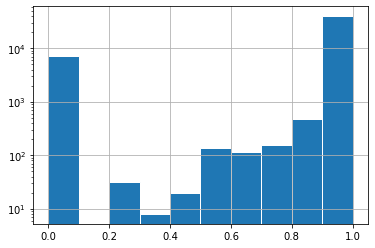

In [62]:
"""Distribution of normalized growth rates"""
fba_norm.stack().hist(ec='w')
plt.yscale('log')
plt.show()

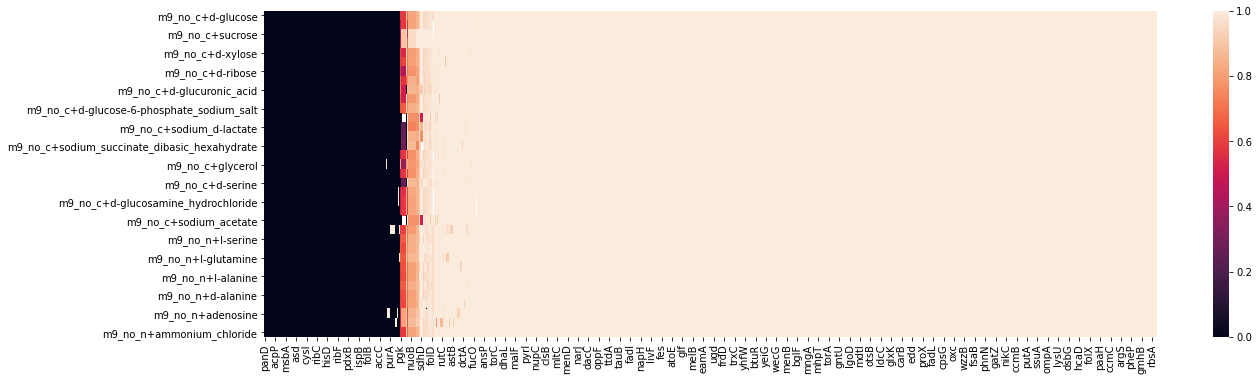

In [63]:
"""Normalized fitness of all mutants"""
plt.figure(figsize=(20, 6))
order = fba_norm.mean(1).sort_values().index
sns.heatmap(fba_norm.reindex(order).T, cmap='rocket')
plt.show()

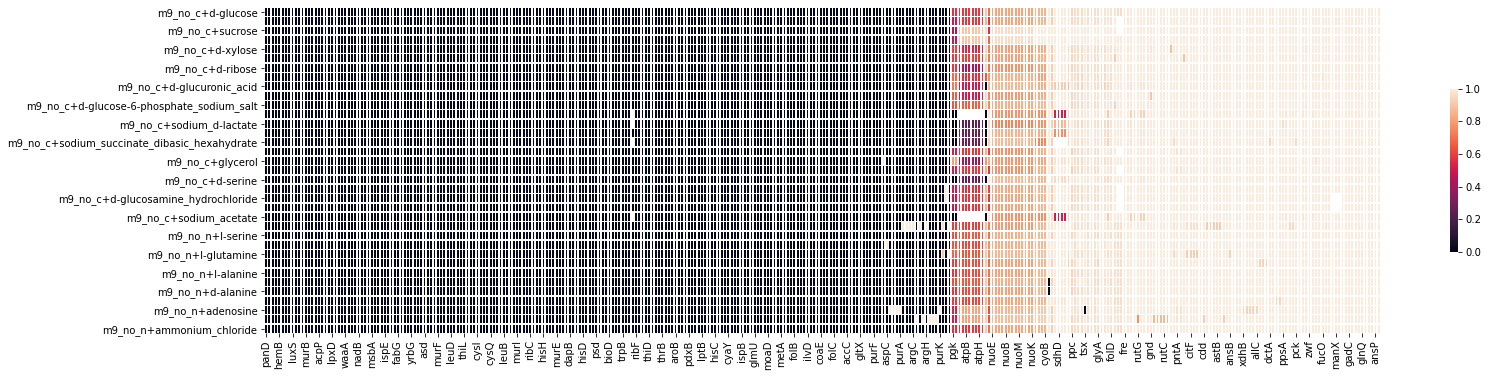

In [64]:
"""Heatmap of <1"""
plt.figure(figsize=(25, 6))
fba_effect = fba_norm[fba_norm.round(4).lt(1).any(1)]
order = fba_effect.mean(1).sort_values().index
sns.heatmap(fba_effect.reindex(order).T, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

## Results stats

In [39]:
fba.shape, fba.size

((1368, 35), 47880)

In [37]:
conds = fba.columns
counts = {}
for c in conds:
    if 'no_c' in c:
        counts['no_c'] = counts.get('no_c', 0) + 1
    else:
        counts['no_n'] = counts.get('no_n', 0) + 1
counts

{'no_c': 23, 'no_n': 12}